In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager

import ast

import statsmodels.api as sm

import statsmodels.formula.api as smf

from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
book_interaction = pd.read_csv("../../s1/book_interaction_filter.csv")
book_description = pd.read_pickle("../../s1/book_description_with_embedding.pkl")

In [3]:
book_interaction.shape

(2111934, 7)

In [4]:
book_interaction = book_interaction[book_interaction.overall > 0]

In [5]:
book_description["avg_rating"] = book_description.avg_rating.astype(float)

In [6]:
book_description["rating_dispersion"] = \
(((1 - book_description.avg_rating) ** 2 * book_description.rating_1_count +\
(2 - book_description.avg_rating) ** 2 * book_description.rating_2_count+\
(3 - book_description.avg_rating) ** 2 * book_description.rating_3_count+\
(4 - book_description.avg_rating) ** 2 * book_description.rating_4_count+\
(5 - book_description.avg_rating) ** 2 * book_description.rating_5_count) / \
(book_description.rating_1_count + \
 book_description.rating_2_count + \
 book_description.rating_3_count + \
 book_description.rating_4_count + \
 book_description.rating_5_count))


In [7]:
book_interaction.columns

Index(['Unnamed: 0', 'overall', 'reviewerID', 'unixReviewTime', 'asin', 'date',
       'order'],
      dtype='object')

In [8]:
book_interaction = book_interaction.sort_values(["reviewerID", "order"])[["overall", "reviewerID", "unixReviewTime", "asin", "order"]].reset_index(drop=True)
book_interaction.columns = ["overall", "reviewerID", "unixReviewTime", "isbn", "order"]

In [10]:
book_description = book_description[["isbn", "embedding", "genre_top", "avg_rating", "rating_dispersion", "review_count"]]

In [11]:
book_interaction.head()

,overall,reviewerID,unixReviewTime,isbn,order
0,5.0,A0020356UF96ZV361ST,1433376000,1508785929,0
1,5.0,A0020356UF96ZV361ST,1433721600,1512208086,1
2,5.0,A0020356UF96ZV361ST,1433808000,1940574366,2
3,4.0,A0020356UF96ZV361ST,1433894400,1938442881,3
4,4.0,A0020356UF96ZV361ST,1434153600,1940574390,4


In [12]:
book_interaction.shape

(2111933, 5)

In [13]:
book_interaction.reviewerID.unique().shape

(35478,)

In [15]:
book_description = book_description[book_description.isbn.isin(book_interaction.isbn.unique())]

In [16]:
book_description.shape

(416797, 6)

In [17]:
from scipy.spatial.distance import pdist

In [18]:
book_embeddings = np.array(book_description.embedding.tolist())

In [19]:
book_embeddings.shape

(416797, 384)

In [20]:
book_interaction = book_interaction.merge(book_description, how="left", on="isbn")

In [21]:
book_interaction["embedding_na"] = book_interaction["embedding"].isna()

In [22]:
book_interaction[book_interaction.embedding_na].isbn.unique().shape

(8368,)

In [23]:
book_interaction = book_interaction[~book_interaction.embedding.isna()] # filter out reading reacords that do not have a goodreads metadata

In [24]:
print(book_interaction.groupby("reviewerID").count().isbn.mean()) # average reading count 

58.73019899656125

In [25]:
print(book_interaction.groupby("reviewerID").count().isbn.std()) # std reading count 

40.37408909971268

In [26]:
book_interaction.reviewerID.unique().shape # N of readers

(35478,)

In [27]:
book_interaction.shape # N of records

(2083630, 11)

In [28]:
(2111933 - 2083630)/2083630 # % of records that do not have metadata

0.013583505708787068

In [29]:
(2111933 - 2083630) # N of records that do not have metadata

28303

In [266]:
book_interaction.isbn.unique().shape # N of unique books

(416797,)

In [267]:
book_interaction.unixReviewTime.min() 

862185600

In [268]:
book_interaction.unixReviewTime.max()

1538092800

In [30]:
gr = book_interaction.sort_values('unixReviewTime').groupby('reviewerID')
book_interaction['order'] = gr.cumcount()

In [ ]:
from scipy.spatial.distance import pdist, squareform
import pickle

def get_point_to_set_distance_eucliean(embedding, compare=1):
    dist_matrix = squareform(pdist(np.array(embedding), 'euclidean'))
    mask_matrix = np.zeros(dist_matrix.shape)
    mask_matrix[np.triu_indices(mask_matrix.shape[0])] = 1
    mask_matrix[np.tril_indices(mask_matrix.shape[0], k=-(compare+1))] = 1
    masked_dist_matrix = np.ma.array(dist_matrix, mask = mask_matrix)
    distance_min = masked_dist_matrix.min(axis=1).data[1:]  
    
    return distance_min


df_list = []

for name, group in tqdm(book_interaction.groupby('reviewerID')):
    user = group["reviewerID"]
    embedding = np.array(group["embedding"].tolist())
    
    group["overall"] = group["overall"] 
    rating = np.array(group["overall"].tolist())

    overall_before = np.append(np.nan, group.overall)[:-1]
    overall_before_before = np.append(np.nan, overall_before)[:-1]
    step_sizes = get_point_to_set_distance_eucliean(embedding)
    step_size_after = np.append(step_sizes, np.nan)
    step_size_before = np.append(np.nan, step_sizes)
    step_size_before_before = np.append(np.nan, step_size_before)[:-1]
    
    avg_rating_after = np.append(group.avg_rating.iloc[1:], np.nan)
    rating_dispersion_after = np.append(group.rating_dispersion.iloc[1:], np.nan)
    review_count_after = np.append(group.review_count.iloc[1:], np.nan)
    
    explore_distance = get_point_to_set_distance_eucliean(embedding, compare=999)
    explore_distance_after = np.append(explore_distance, np.nan)
    explore_distance_before = np.append(np.nan, explore_distance)
    explore_distance_before_before = np.append(np.nan, explore_distance_before)[:-1]
    
    record = {"user": user.unique()[0],
             "rating": rating,
             "step_size_after": step_size_after,
             "step_size_before": step_size_before,
             "step_size_before_before": step_size_before_before,
             "avg_rating_after": avg_rating_after, 
             "rating_dispersion_after": rating_dispersion_after,
             "overall": rating,
             "overall_before": overall_before,
              "overall_before_before": overall_before_before, 
             "explore_distance_after": explore_distance_after,
             "explore_distance_before": explore_distance_before,
             "explore_distance_before_before": explore_distance_before_before,
             "review_count_after": review_count_after}
    df_list.append(record)

In [34]:
book_interaction.loc[:, "step_size_after"] = np.concatenate([record["step_size_after"] for record in df_list])
book_interaction.loc[:, "step_size_before"] = np.concatenate([record["step_size_before"] for record in df_list])
book_interaction.loc[:, "step_size_before_before"] = np.concatenate([record["step_size_before_before"] for record in df_list])

book_interaction.loc[:, "overall_new"] = np.concatenate([record["overall"] for record in df_list])
book_interaction.loc[:, "overall_before"] = np.concatenate([record["overall_before"] for record in df_list])
book_interaction.loc[:, "overall_before_before"] = np.concatenate([record["overall_before_before"] for record in df_list])

book_interaction.loc[:, "avg_rating_after"] = np.concatenate([record["avg_rating_after"] for record in df_list])
book_interaction.loc[:, "rating_dispersion_after"] = np.concatenate([record["rating_dispersion_after"] for record in df_list])
book_interaction.loc[:, "review_count_after"] = np.concatenate([record["review_count_after"] for record in df_list])
book_interaction["review_count_log_after"] = np.log(book_interaction.review_count_after)

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
book_interaction.head()

,overall,reviewerID,unixReviewTime,isbn,order,embedding,genre_top,avg_rating,rating_dispersion,review_count,...,step_size_after,step_size_before,step_size_before_before,overall_new,overall_before,overall_before_before,avg_rating_after,rating_dispersion_after,review_count_after,review_count_log_after
0,5.0,A0020356UF96ZV361ST,1433376000,1508785929,0,"[-0.09414349496364594, -0.03927240148186684, -...",NaN,4.69,0.512159,40.0,...,1.168234,NaN,NaN,5.0,NaN,NaN,4.53,0.573603,14.0,2.639057
1,5.0,A0020356UF96ZV361ST,1433721600,1512208086,1,"[-0.11971894651651382, -0.04757317900657654, -...",NaN,4.53,0.573603,14.0,...,1.073847,1.168234,NaN,5.0,5.0,NaN,4.71,0.348066,27.0,3.295837
2,5.0,A0020356UF96ZV361ST,1433808000,1940574366,2,"[-0.08566500246524811, -0.004923059605062008, ...",African American,4.71,0.348066,27.0,...,1.087226,1.073847,1.168234,5.0,5.0,5.0,4.53,0.628141,32.0,3.465736
3,4.0,A0020356UF96ZV361ST,1433894400,1938442881,3,"[-0.06995930522680283, -0.0741531103849411, 0....",NaN,4.53,0.628141,32.0,...,0.957763,1.087226,1.073847,4.0,5.0,5.0,4.47,0.799432,26.0,3.258097
4,4.0,A0020356UF96ZV361ST,1434153600,1940574390,4,"[-0.05623221397399902, -0.09144005924463272, 0...",NaN,4.47,0.799432,26.0,...,0.984077,0.957763,1.087226,4.0,4.0,5.0,4.70,0.397927,61.0,4.110874


In [37]:
book_description = book_description[book_description.isbn.isin(book_interaction.isbn.unique())]

In [38]:
book_description.shape

(416797, 6)

In [40]:
book_interaction.shape

(2083630, 21)

Text(0, 0.5, 'Reading Enjoyment')

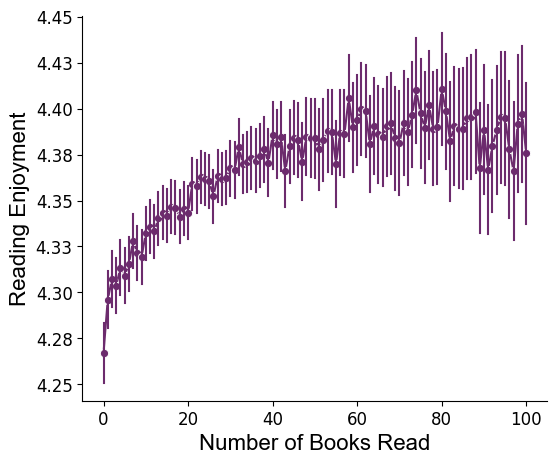

In [175]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=book_interaction[book_interaction.order_new <=100],
             x="order_new",
             y="overall", errorbar=("se", 2.576),err_style="bars",
              marker="o",
             dashes=True, color=sns.color_palette("flare")[-1])

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Reading Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [152]:
from scipy.stats import pearsonr

In [157]:
r_res = pearsonr(book_interaction.order_new, book_interaction.overall)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=0.022357699086130937, pvalue=6.5499303462386995e-211)
ConfidenceInterval(low=0.020500214574323, high=0.024215029254362218)


Text(0, 0.5, 'Average Rating')

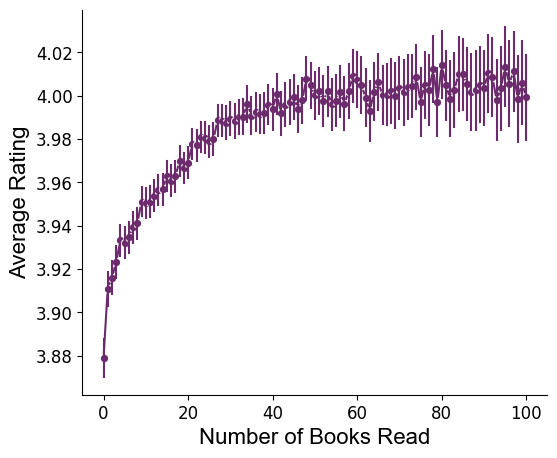

In [291]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=book_interaction[book_interaction.order_new <=100],
             x="order_new",
             y="avg_rating", errorbar=("se", 2.576),err_style="bars",
              marker="o",
             dashes=True, color=sns.color_palette("flare")[-1])


ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Average Rating", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [293]:
r_res = pearsonr(book_interaction.order_new, book_interaction.avg_rating)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=0.03412786418871174, pvalue=0.0)
ConfidenceInterval(low=0.03234537478331954, high=0.035910136500891365)


In [42]:
sns.color_palette(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

Text(0, 0.5, 'Explore Distance')

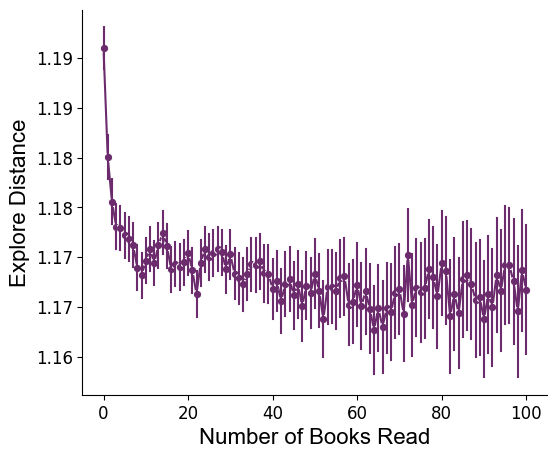

In [174]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=book_interaction[book_interaction.order_new <=100],
             x="order_new",
             y="step_size_after", errorbar=("se",  2.576),err_style="bars",
             marker="o",
             dashes=True, color=sns.color_palette("flare")[-1])


ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [160]:
r_res = pearsonr(book_interaction[~book_interaction.step_size_after.isna()].order_new, 
                 book_interaction[~book_interaction.step_size_after.isna()].step_size_after)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=-0.005726425189030277, pvalue=3.5080840029645796e-15)
ConfidenceInterval(low=-0.007600276552671614, high=-0.0038525336085966947)


Text(0, 0.5, 'Subsequent Explore Distance')

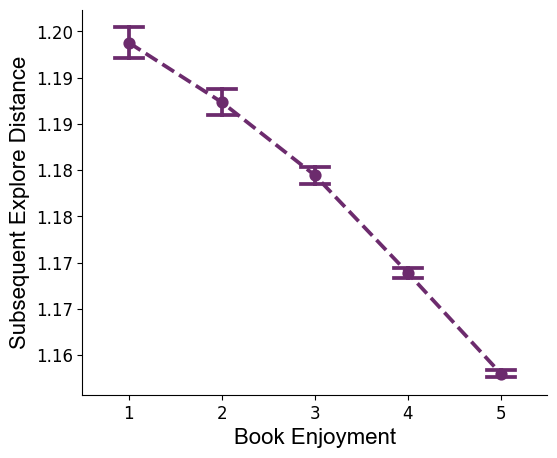

In [216]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.pointplot(data=book_interaction,
             x=book_interaction.overall.astype(int), capsize=.3,
             y="step_size_after", 
             errorbar=("se", 2.576),linestyle="--",
             markers="o",  color=sns.color_palette("flare")[-1])

ax.spines[['right', 'top']].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Book Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Subsequent Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [40]:
distance_distribution = pdist(book_embeddings[np.random.randint(book_embeddings.shape[0], size=10000),:])

In [41]:
distance_distribution.mean()

1.3012932658730236

In [42]:
distance_distribution.std()

0.09003578976083453

In [44]:
distance_distribution.shape

(49995000,)

In [48]:
distance_distribution[np.random.randint(distance_distribution.shape[0], size=10000)].shape

(10000,)

In [94]:
book_interaction.step_size_after.mean()

1.1695977361713272

In [ ]:
np.random.seed(123)

In [115]:
mu1 = distance_distribution[np.random.randint(distance_distribution.shape[0], size=100000)].mean()
std1 = distance_distribution[np.random.randint(distance_distribution.shape[0], size=100000)].std()
se1 = std1/np.sqrt(49995000**2/2)

In [118]:
se1

2.5516649319104585e-09

In [111]:
mu2 = book_interaction.step_size_after.mean()
std2 = book_interaction.step_size_after.std()
se2 = std2/np.sqrt(book_interaction.shape[0])

In [109]:
book_interaction.shape

(1921256, 30)

In [116]:
z = (mu2 - mu1)/np.sqrt(se2**2 + se1**2)

In [117]:
z

-1172.3405095391975

Text(0, 0.5, 'Probability Density')

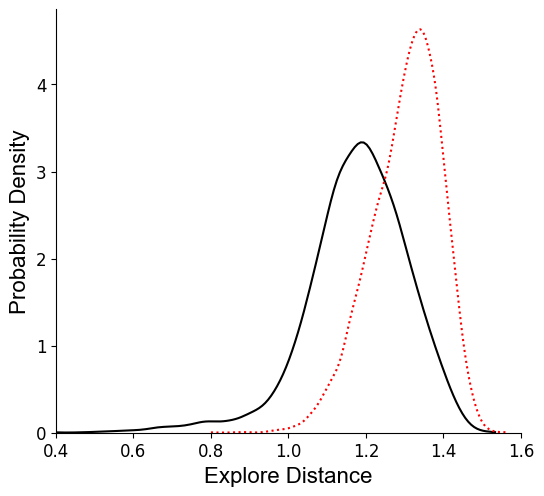

In [86]:
fig, ax = plt.subplots(figsize=(6, 5.5))

sns.kdeplot(book_interaction.step_size_after.sample(10000), color="black", cut=0)
sns.kdeplot(distance_distribution[np.random.randint(distance_distribution.shape[0], size=10000)], 
            color="red", 
            linestyle=":", cut=0)

plt.xlim(0.4, 1.6)

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Probability Density", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [168]:
book_interaction.to_csv("s1_stats_test_final.csv") # save data for mixed effect modeling in R

In [65]:
book_interaction.dropna(subset = ['overall'], inplace=True)

In [66]:
book_interaction = book_interaction.reset_index(drop=True)

In [175]:
r_res = pearsonr(book_interaction[~book_interaction.step_size_before.isna() & (book_interaction.review_count_log > 0)].review_count_log, 
                 book_interaction[~book_interaction.step_size_before.isna() & (book_interaction.review_count_log > 0)].step_size_before)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=-0.041748474944075575, pvalue=0.0)
ConfidenceInterval(low=-0.043658558922128055, high=-0.03983808575337106)


Text(0, 0.5, 'Explore Distance')

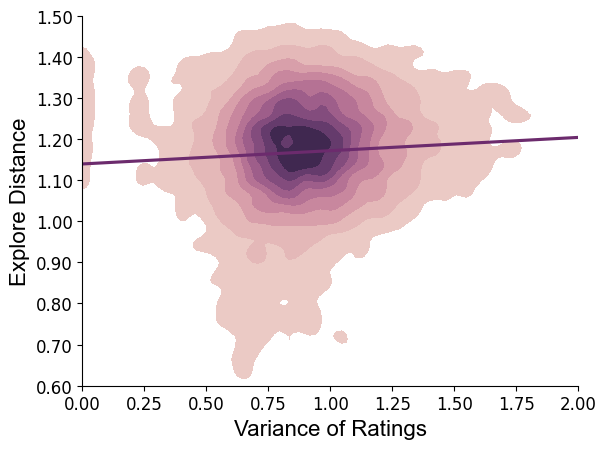

In [125]:
# sns.set_style("white")
sns.kdeplot(x=book_interaction.sample(10000, random_state=123).rating_dispersion,
            y=book_interaction.sample(10000, random_state=123).step_size_before, 
            cmap=sns.cubehelix_palette(as_cmap=True),
            fill=True, bw_adjust=0.5)

sns.regplot(data=book_interaction,
           x="rating_dispersion",
             y="step_size_before",
            color=sns.color_palette("flare")[-1],
            ci=99, scatter=False)

plt.ylim(0.6, 1.5)
plt.xlim(0, 2)

sns.despine()
# ax.set_xticks([1, 2, 3, 4, 5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
# plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Variance of Ratings", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})


In [180]:
r_res = pearsonr(book_interaction[book_interaction.review_count_log > 0][["rating_dispersion", "step_size_before"]].dropna().rating_dispersion, 
                 book_interaction[book_interaction.review_count_log > 0][["rating_dispersion", "step_size_before"]].dropna().step_size_before)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=0.07601366266794346, pvalue=0.0)
ConfidenceInterval(low=0.0741108692782647, high=0.07791590258614513)


# Computational modeling

In [94]:
df_list = []

for name, group in tqdm(book_interaction.groupby('reviewerID')):
    user = group["reviewerID"]
    embedding = np.array(group["embedding"].tolist())
    step_sizes = get_point_to_set_distance_eucliean(embedding)
    rating = np.array(group["overall"].tolist())

    
    rating_new = rating - group["overall"].mean()
    avg_rating = np.array(group["avg_rating"].tolist())
    rating_dispersion = np.array(group["rating_dispersion"].tolist())
    review_count = np.array(group["review_count"].tolist())
    
    learning_rate = pearsonr(group.overall, group.order_new)[0]

    record = {"user": user.unique()[0],
              "improving_rate": pearsonr(group.overall, group.order_new)[0],
             "books": embedding,
             "rating": rating,
              "rating_new": rating_new,
             "avg_rating": avg_rating,
             "rating_dispersion": rating_dispersion,
              "review_count": review_count,
              "step_sizes": step_sizes, 
             "learning_rate": learning_rate}
    if (~np.isnan(rating)).all() and ~(np.var(rating) == 0):
        df_list.append(record)

100%|████████████████████████████████████| 31848/31848 [01:20<00:00, 394.26it/s]


In [95]:
mean_book_embedding = np.array(book_description.embedding.tolist()).mean(axis=0)

In [100]:
# input embeddings
# input ratings
# output m_vec and v_vec
from sklearn.metrics.pairwise import euclidean_distances
from numpy import linalg

starting_index = 1
def get_null_log_likelihood(book_embedding, compare_book_embedding):
    """
    Get the null log_likelihood of the models in the leave-out-out prediction
    Output: sum of null log likelihood
    """
    
    ll_null = 0
    
    for i in range(starting_index, book_embedding.shape[0]-1):
    
        ll = np.log(1/(1+compare_book_embedding.shape[0]))
        ll_null = ll_null - ll
        
    return ll_null
    

def model_guassian_log_likelihood(X, rating, l2_matrix):
    """
    Estimate the model and get the log_likelihood using leave-one-out CV
    Compare the choice with random sampled books
    Input X: X[0] == gamma, X[1] == eta, X[3] == beta (only for ucb)
    Output: loss log likelihood
    """
    
    gamma = X[0]
    eta = X[1]
    compare_set_length = l2_matrix.shape[0]-rating.shape[0]
    last_index = [i for i in np.arange(-compare_set_length ,0)]

    rating_new = np.array(rating) - np.mean(rating)

    K_matrix = np.exp(-l2_matrix**2/gamma)
    
    sigma_square = 1
    ll_sum = 0
    for i in range(starting_index, K_matrix.shape[0]-compare_set_length-1):
        testing_index = [i+1]+last_index
        k_matrix = K_matrix[:(i+1),:(i+1)]
        k_inv = linalg.inv(k_matrix + np.eye(k_matrix.shape[0]) * sigma_square)
        k_vec = K_matrix[:(i+1),[i+1]+last_index] 
        m_vec = k_vec.T.dot(k_inv).dot(rating_new[:(i+1)])
        v_vec = K_matrix.diagonal()[[i+1]+last_index] - k_vec.T.dot(k_inv).dot(k_vec).diagonal()
        
        q = m_vec
        p = np.exp(q*eta)/np.sum(np.exp(q*eta))
    
        ll = np.log(p[0])
        ll_sum = ll_sum - ll
        
    return ll_sum


def model_ucb_log_likelihood(X, rating, l2_matrix):
    """
    Estimate the model and get the log_likelihood using leave-one-out CV
    Compare the choice with random sampled books
    Input X: X[0] == gamma, X[1] == eta, X[3] == beta (only for ucb)
    Output: loss log likelihood
    """
    
    gamma = X[0]
    eta = X[1]
    beta = X[2]

    rating_new = np.array(rating) - np.mean(rating)

    compare_set_length = l2_matrix.shape[0]-rating.shape[0]
    last_index = [i for i in np.arange(-compare_set_length ,0)]
    
    K_matrix = np.exp(-l2_matrix**2/gamma)

    sigma_square = 1
    ll_sum = 0
    for i in range(starting_index, K_matrix.shape[0]-compare_set_length-1):
        testing_index = [i+1]+last_index
        k_matrix = K_matrix[:(i+1),:(i+1)]
        k_inv = linalg.inv(k_matrix + np.eye(k_matrix.shape[0]) * sigma_square)
        k_vec = K_matrix[:(i+1),[i+1]+last_index] 
        m_vec = k_vec.T.dot(k_inv).dot(rating_new[:(i+1)])
        v_vec = K_matrix.diagonal()[[i+1]+last_index] - k_vec.T.dot(k_inv).dot(k_vec).diagonal()
        
        q = m_vec + beta * np.sqrt(v_vec)
        p = np.exp(q*eta)/np.sum(np.exp(q*eta))
    
        ll = np.log(p[0])
        ll_sum = ll_sum - ll
        
    return ll_sum

In [186]:
x0_guassian = (0.5, 1)
x0_ucb = (0.5, 1, 1)

ll_guassian_list = []
ll_ucb_list = []
ll_null_list = []

for df in tqdm(df_list):

    rating = df["rating"]
    rating_new = df["rating"] - np.mean(df["rating"])
    book_embedding = df["books"]

    compare_book_embedding = mean_book_embedding.reshape(1,384)
    
    book_all_embedding = np.concatenate((book_embedding, compare_book_embedding), axis=0)
    
    l2_matrix = euclidean_distances(book_all_embedding)

    ll_null = get_null_log_likelihood(book_embedding, compare_book_embedding)

    ll_guassian = model_guassian_log_likelihood(x0_guassian, rating, l2_matrix)

    ll_ucb = model_ucb_log_likelihood(x0_ucb, rating, l2_matrix)

    ll_guassian_list.append(ll_guassian)
    
    ll_ucb_list.append(ll_ucb)
    
    ll_null_list.append(ll_null)

print((1-np.array(ll_guassian_list)/np.array(ll_null_list)).mean())
print((1-np.array(ll_ucb_list)/np.array(ll_null_list)).mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31848/31848 [13:29<00:00, 39.36it/s]

0.014965416159617329
0.10741325909321067


In [189]:
test_test = pd.DataFrame.from_records(df_list[:len(ll_null_list)])[["user"]]

test_test["r_squared_guassian"] = (1-np.array(ll_guassian_list)/np.array(ll_null_list))
test_test["r_squared_ucb"] = (1-np.array(ll_ucb_list)/np.array(ll_null_list))

In [193]:
from statsmodels.stats.weightstats import ztest
import scipy

In [203]:
print(ztest(test_test["r_squared_guassian"]))
print(test_test["r_squared_guassian"].mean())
se = test_test["r_squared_guassian"].std()/np.sqrt(test_test["r_squared_guassian"].shape[0])
print(se)
critical_z_99 = scipy.stats.norm.ppf(1-.01/2) 
print(test_test["r_squared_guassian"].mean() + critical_z_99 * se)
print(test_test["r_squared_guassian"].mean() - critical_z_99 * se)

(30.01075788679118, 7.103583871712196e-198)
0.014965416159617329
0.0004986683847196057
0.016249900797731486
0.01368093152150317


In [205]:
print(ztest(test_test["r_squared_ucb"] - test_test["r_squared_guassian"]))
print(test_test["r_squared_ucb"].mean())
se = test_test["r_squared_ucb"].std()/np.sqrt(test_test["r_squared_ucb"].shape[0])
print(se)
critical_z_99 = scipy.stats.norm.ppf(1-.01/2) 
print(test_test["r_squared_ucb"].mean() + critical_z_99 * se)
print(test_test["r_squared_ucb"].mean() - critical_z_99 * se)

(512.134483965098, 0.0)
0.10741325909321067
0.0004993018969064876
0.10869937555057996
0.10612714263584139


/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'Predictive Accuracy')

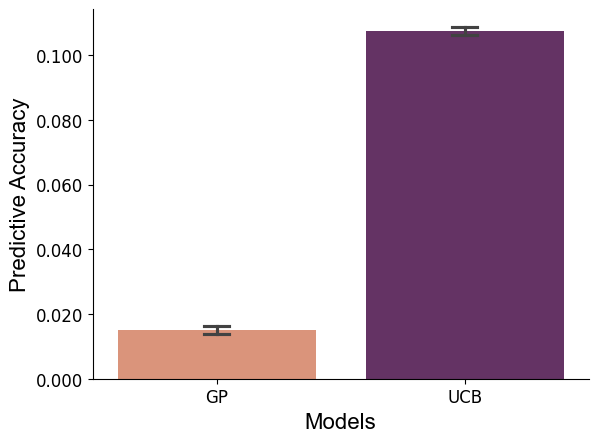

In [282]:
from matplotlib.ticker import StrMethodFormatter
sns.barplot((test_test.r_squared_guassian, test_test.r_squared_ucb), 
            palette = [sns.color_palette("flare")[0], 
            sns.color_palette("flare")[-1]], errorbar=('ci', 99), capsize=.1)


sns.despine()
plt.xticks([0, 1], ['GP', 'UCB'], fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
plt.xlabel("Models", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Predictive Accuracy", fontdict={'fontfamily': 'Arial', 'fontsize': 16})